# Flames - Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 8, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard features used by the StellarAlgo retention model.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [92]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [94]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [ ]:
lkupclientid = 36 # flames

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrFlames].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [192]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "clickToOpenRatio", 
    "clickToSendRatio",
    "distToVenue",
    "inperson_contact",
    "isNextYear_Buyer",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "totalSpent",
    "year"
]

# choose the features & train year & test year
df = df[features]
df["year"] = pd.to_numeric(df["year"])

df_train = df.loc[df["year"] <= 2019]
df_train = df_train.sample(frac=0.95, random_state=786).reset_index(drop=True)

df_eval = df.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (31792, 17)
Unseen Data For Predictions: (6670, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [193]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ]
);

In [194]:
model_matrix = compare_models(
    fold=10,
    include=["xgboost"],
    sort="AUC"
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9072,0.9271,0.9722,0.9027,0.9362,0.7672,0.7745,0.8850


### The top model is performing well, so let's compare it against our unseen evaluation dataset:

In [195]:
best_model = create_model(model_matrix)
tuned_model = tune_model(best_model, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8939,0.9243,0.9949,0.8716,0.9292,0.7212,0.7469
1,0.8856,0.9206,0.9978,0.8609,0.9243,0.6956,0.7283
2,0.8852,0.9280,0.9966,0.8612,0.9240,0.6950,0.7268
3,0.8891,0.9320,0.9978,0.8646,0.9264,0.7061,0.7368
4,0.8970,0.9320,0.9972,0.8735,0.9312,0.7294,0.7555
5,0.8824,0.9269,0.9933,0.8603,0.9220,0.6883,0.7184
6,0.8934,0.9378,0.9961,0.8703,0.9290,0.7196,0.7464
7,0.8911,0.9260,0.9949,0.8685,0.9274,0.7131,0.7402
8,0.8954,0.9373,0.9978,0.8714,0.9303,0.7243,0.7517
9,0.8879,0.9220,0.9966,0.8641,0.9256,0.7028,0.7331


### Let's plot the features to see what attributes were the most important to an accurate prediction

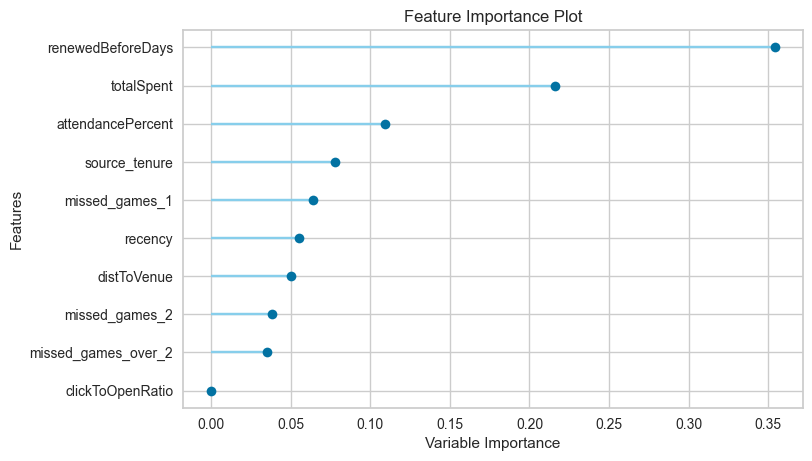

In [196]:
plot_model(tuned_model, plot='feature')

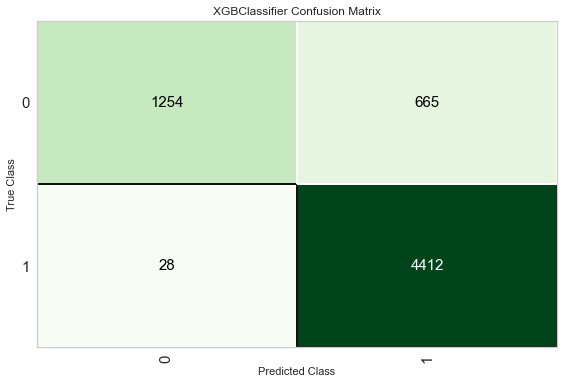

In [197]:
plot_model(tuned_model, plot='confusion_matrix')

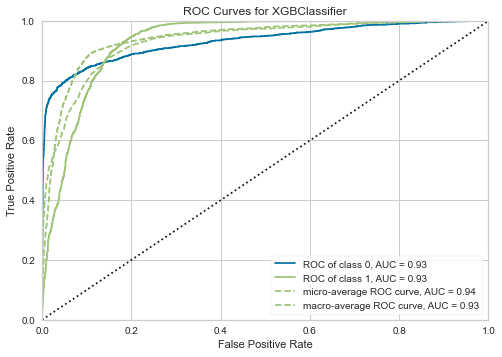

In [198]:
plot_model(tuned_model, plot='auc')

In [200]:
unseen_predictions = predict_model(tuned_model)

unseen_predictions
print(unseen_predictions['Label'].value_counts())
unseen_predictions['Score'].value_counts(bins=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8910,0.9312,0.9937,0.8690,0.9272,0.7145,0.7404


1    5077
0    1282
Name: Label, dtype: int64


(0.875, 1.0]     5911
(0.75, 0.875]     203
(0.626, 0.75]     138
(0.5, 0.626]      107
Name: Score, dtype: int64